In [755]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2

# Load camera poses
# Each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to points expressed in the camera frame.

pose_vectors = np.loadtxt('data/poses.txt')

# Define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

k=np.loadtxt('data/K.txt') #calibration matrix [3x3]
d=np.loadtxt('data/D.txt') #distortion coefficients [2x1]

img_idx=1
path = 'data/images_undistorted/'
fname = path+"img_{:04d}.jpg".format(img_idx)

img = Image.open(fname).convert('LA')
img.save(path+"img_grey_{:04d}.png".format(img_idx))

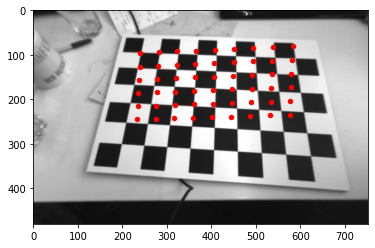

In [767]:
square_size = 0.04
num_corners_x = 9 
num_corners_y = 6

num_corners = num_corners_x * num_corners_y

#create a grid 

x = np.arange(0, num_corners_x, 1)
y = np.arange(0, num_corners_y, 1)

xx, yy = np.meshgrid(x, y, sparse=False)
xx=np.reshape(xx, (1,-1), order='F')[0]
yy=np.reshape(yy, (1,-1), order='F')[0]

p_W_corners = square_size*np.vstack((xx,yy)) 
zero = np.zeros((1,num_corners))
p_W_corners = np.concatenate((p_W_corners,zero)) # add the z-axis

pose_vec=pose_vectors[img_idx]
RT = poseVectorToTransformationMatrix(pose_vec) # R|T

ones = np.ones((1,len(p_W_corners[0])))
p_C_corners= np.concatenate((p_W_corners,ones))

projected_points= np.dot(RT, p_C_corners)
xpp , ypp = projectPoints(projected_points, k, d) 

#im = np.flipud(plt.imread(fname))
#implot = plt.imshow(im,origin='lower')

im = plt.imread(fname)
implot = plt.imshow(im)
plt.scatter(xpp, ypp, c='r', s=20)
plt.show()

In [766]:
def poseVectorToTransformationMatrix(pose_vec):
    
    'Converts a 6x1 pose vector into a 3x4 transformation matrix'
    
    omega = pose_vec[:3] #w
    t = pose_vec[3:]
    theta = np.linalg.norm(omega) #||w||=θ
    k = omega/theta
    kx, ky, kz = k
    K = [[0,-kz,ky],[kz,0,-kx],[-ky,kx,0]]
    cross=np.cross(K, k)
    #R = np.cos(theta)*cross+(1-np.cos(theta))*(np.dot(cross,cross))
    R = np.eye(3) + np.sin(theta)*cross+(1-np.cos(theta))*(np.dot(cross,cross))
    t = np.expand_dims(t, axis=-1)
    RT=np.concatenate((R, t), axis=1)
    return RT

def projectPoints(points_3d, K, D=np.zeros((4,1))) :
    
    ''' Projects 3d points to the image plane (3xN), given the camera matrix (3x3) and
     distortion coefficients (4x1).'''

    # get image coordinates
    projected_points= np.dot(k, points_3d)
    projected_points=projected_points/projected_points[2:]

    # apply distortion
    return distortPoints(projected_points,D,K)

def distortPoints(projected_points,D,K):
    #distortion
    u0=K[0][2]
    v0=K[1][2]

    xp=projected_points[:1][0]-u0
    yp=projected_points[1:2][0]-v0
    
    d1, d2 = D
    r2 = xp**2 + yp**2
    m = (1 + d1*r2 + d2*r2**2)
    m=1
    xpp = (xp*m+u0)
    ypp = (yp*m+v0)
    
    return xpp, ypp 